<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 148MB/s]


In [ ]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [ ]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 5985


In [ ]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [ ]:
# Definimos el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 2000

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer


# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.

# Tokenizamos (mapeo de palabras a índices)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Construímos un vocabulario con las palabras mas frecuentes y asignamos un índice a cada una
input_tokenizer.fit_on_texts(input_sentences)

# Almacenamos el mapeo de palabras a índices
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

# Calculamos la secuencia de entrada mas larga
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

print("Primeras secuencias tokenizadas de entrada:", input_integer_seq[:5])

Palabras en el vocabulario: 1783
Sentencia de entrada más larga: 9
Primeras secuencias tokenizadas de entrada: [[19], [12, 11, 8, 2], [12], [12], [12]]


In [ ]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

# Calculamos la longitud máxima de las respuestas para poder definir el padding de salida
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1794
Sentencia de salida más larga: 10


In [ ]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 9
max_out_len = 10

In [ ]:
# Hacemos Padding para que todas las secuencias tengan la misma longitud para entrenar el modelo sin problemas

print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 5985
encoder_input_sequences shape: (5985, 9)
decoder_input_sequences shape: (5985, 10)


In [ ]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(5985, 10, 1795)

In [ ]:
total_words = len(word2idx_inputs)
print(f"Palabras totales: {total_words}")
print(f"Palabras fuera del vocabulario: {total_words - MAX_VOCAB_SIZE}")


Palabras totales: 1783
Palabras fuera del vocabulario: -217


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
# Descargamos los embeddings pre-entrenados desde un google drive (es la forma más rápida)

import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=7dee318b-6778-4465-b28a-b920d0d125bd
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:03<00:00, 135MB/s]


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [ ]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

# Crear el embeddings_index
embeddings_index = {word: model_embeddings.get_words_embeddings(word)[0] for word in model_embeddings.idx2word.values()}


In [ ]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38


In [ ]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1783, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [ ]:
def get_dataset(X, Y, label_encoder):
    cardinality = len(label_encoder.classes_)
    print("Number of features/cardinality:", cardinality)

    X1, X2, target = list(), list(), list()
    for x, y in zip(X, Y):
        input = x
        output = y

        # Verificar índices antes de codificar
        if np.any(input >= cardinality) or np.any(input < 0):
            print(f"Índices de entrada fuera de límites: {input}")
            continue

        if np.any(output >= cardinality) or np.any(output < 0):
            print(f"Índices de salida fuera de límites: {output}")
            continue

        # Crear la entrada del "último estado"
        output_in = [0] + output[:-1]

        # transformar
        input_encoded = to_categorical(input, num_classes=cardinality)
        output_encoded = to_categorical(output, num_classes=cardinality)
        output_in_encoded = to_categorical(output_in, num_classes=cardinality)

        # almacenar
        X1.append(input_encoded)
        X2.append(output_in_encoded)
        target.append(output_encoded)

    return np.array(X1), np.array(X2), np.array(target)


In [ ]:
# Definimos X e y
X = encoder_input_sequences
y = decoder_output_sequences

In [ ]:
# Importamos LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Definimos y ajustamos el label_encoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(list(word2idx_outputs.keys())))

# Creamos el dataset
X1, X2, target = get_dataset(X, y, label_encoder)

# Verificamos las formas de las matrices
print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)
print("target shape:", target.shape)

Number of features/cardinality: 1794
Índices de salida fuera de límites: [   2   14 1794    1    0    0    0    0    0    0]
X1 shape: (5984, 9, 1794)
X2 shape: (5984, 9, 1794)
target shape: (5984, 10, 1794)


In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

def define_models(vocab_size_in, vocab_size_out, max_len_input, max_len_output, n_units, embedding_matrix):
    '''
    Args:
        n_input: The cardinality of the input sequence, e.g. number of features, words, or characters for each time step.
        n_output: The cardinality of the output sequence, e.g. number of features, words, or characters for each time step.
        n_units: Size of recurrent layers to use in the encoder and decoder models, e.g. 128 or 256.
    output:
        train: Model that can be trained given source, target, and shifted target sequences.
        inference_encoder: Encoder model used when making a prediction for a new source sequence.
        inference_decoder Decoder model use when making a prediction for a new source sequence.
    '''
    # Definimos el encoder
    encoder_inputs = Input(shape=(max_len_input,))
    encoder_embedding = Embedding(vocab_size_in, embed_dim, weights=[embedding_matrix], input_length=max_len_input, trainable=False)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(n_units, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Definimos el decoder
    decoder_inputs = Input(shape=(max_len_output,))
    decoder_embedding = Embedding(vocab_size_out, embed_dim)(decoder_inputs)  # Embeddings aprendidos
    decoder_lstm, _, _ = LSTM(n_units, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(vocab_size_out, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Modelo de entrenamiento
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Definimos el modelo para la inferencia (encoder)
    encoder_model = Model(encoder_inputs, encoder_states)

    # Definimos el modelo para la inferencia (decoder)
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm_inf, state_h_inf, state_c_inf = LSTM(n_units, return_sequences=True, return_state=True)(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states_inf = [state_h_inf, state_c_inf]
    decoder_outputs_inf = decoder_dense(decoder_lstm_inf)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs_inf] + decoder_states_inf)

    return model, encoder_model, decoder_model

In [ ]:
print("Tamaño del vocabulario de entrada:", len(word2idx_inputs) + 1)  # +1 por <UNK>
print("Tamaño del vocabulario de salida:", len(word2idx_outputs) + 1)  # +1 por <UNK>

Tamaño del vocabulario de entrada: 1784
Tamaño del vocabulario de salida: 1795


In [ ]:
print("Forma de la embedding_matrix:", embedding_matrix.shape)

Forma de la embedding_matrix: (1783, 50)


In [ ]:
import numpy as np

embedding_dim = 50
vocab_size_in = len(word2idx_inputs) + 1  # +1 por <UNK>
embedding_matrix = np.zeros((vocab_size_in, embedding_dim))

for word, i in word2idx_inputs.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

# Verificamos la forma de la matriz de embeddings
print("Forma de la embedding_matrix:", embedding_matrix.shape)


Forma de la embedding_matrix: (1784, 50)


In [ ]:
# Parámetros del modelo
n_units = 128
vocab_size_in = len(word2idx_inputs) + 1  # +1 para incluir el token <UNK>
vocab_size_out = len(word2idx_outputs) + 1  # +1 para incluir el token <UNK>

# Definimos los modelos
model, encoder_model, decoder_model = define_models(
    vocab_size_in, vocab_size_out, max_input_len, max_out_len, n_units, embedding_matrix)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Vemos la arquitectura del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 9, 50)          │         89,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 10, 50)         │         89,750 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │         91,648 │ embedding[0][0]        │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 10, 128),      │         91,648 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 1795)       │        231,555 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 593,801 (2.27 MB)

 Trainable params: 504,601 (1.92 MB)

 Non-trainable params: 89,200 (348.44 KB)

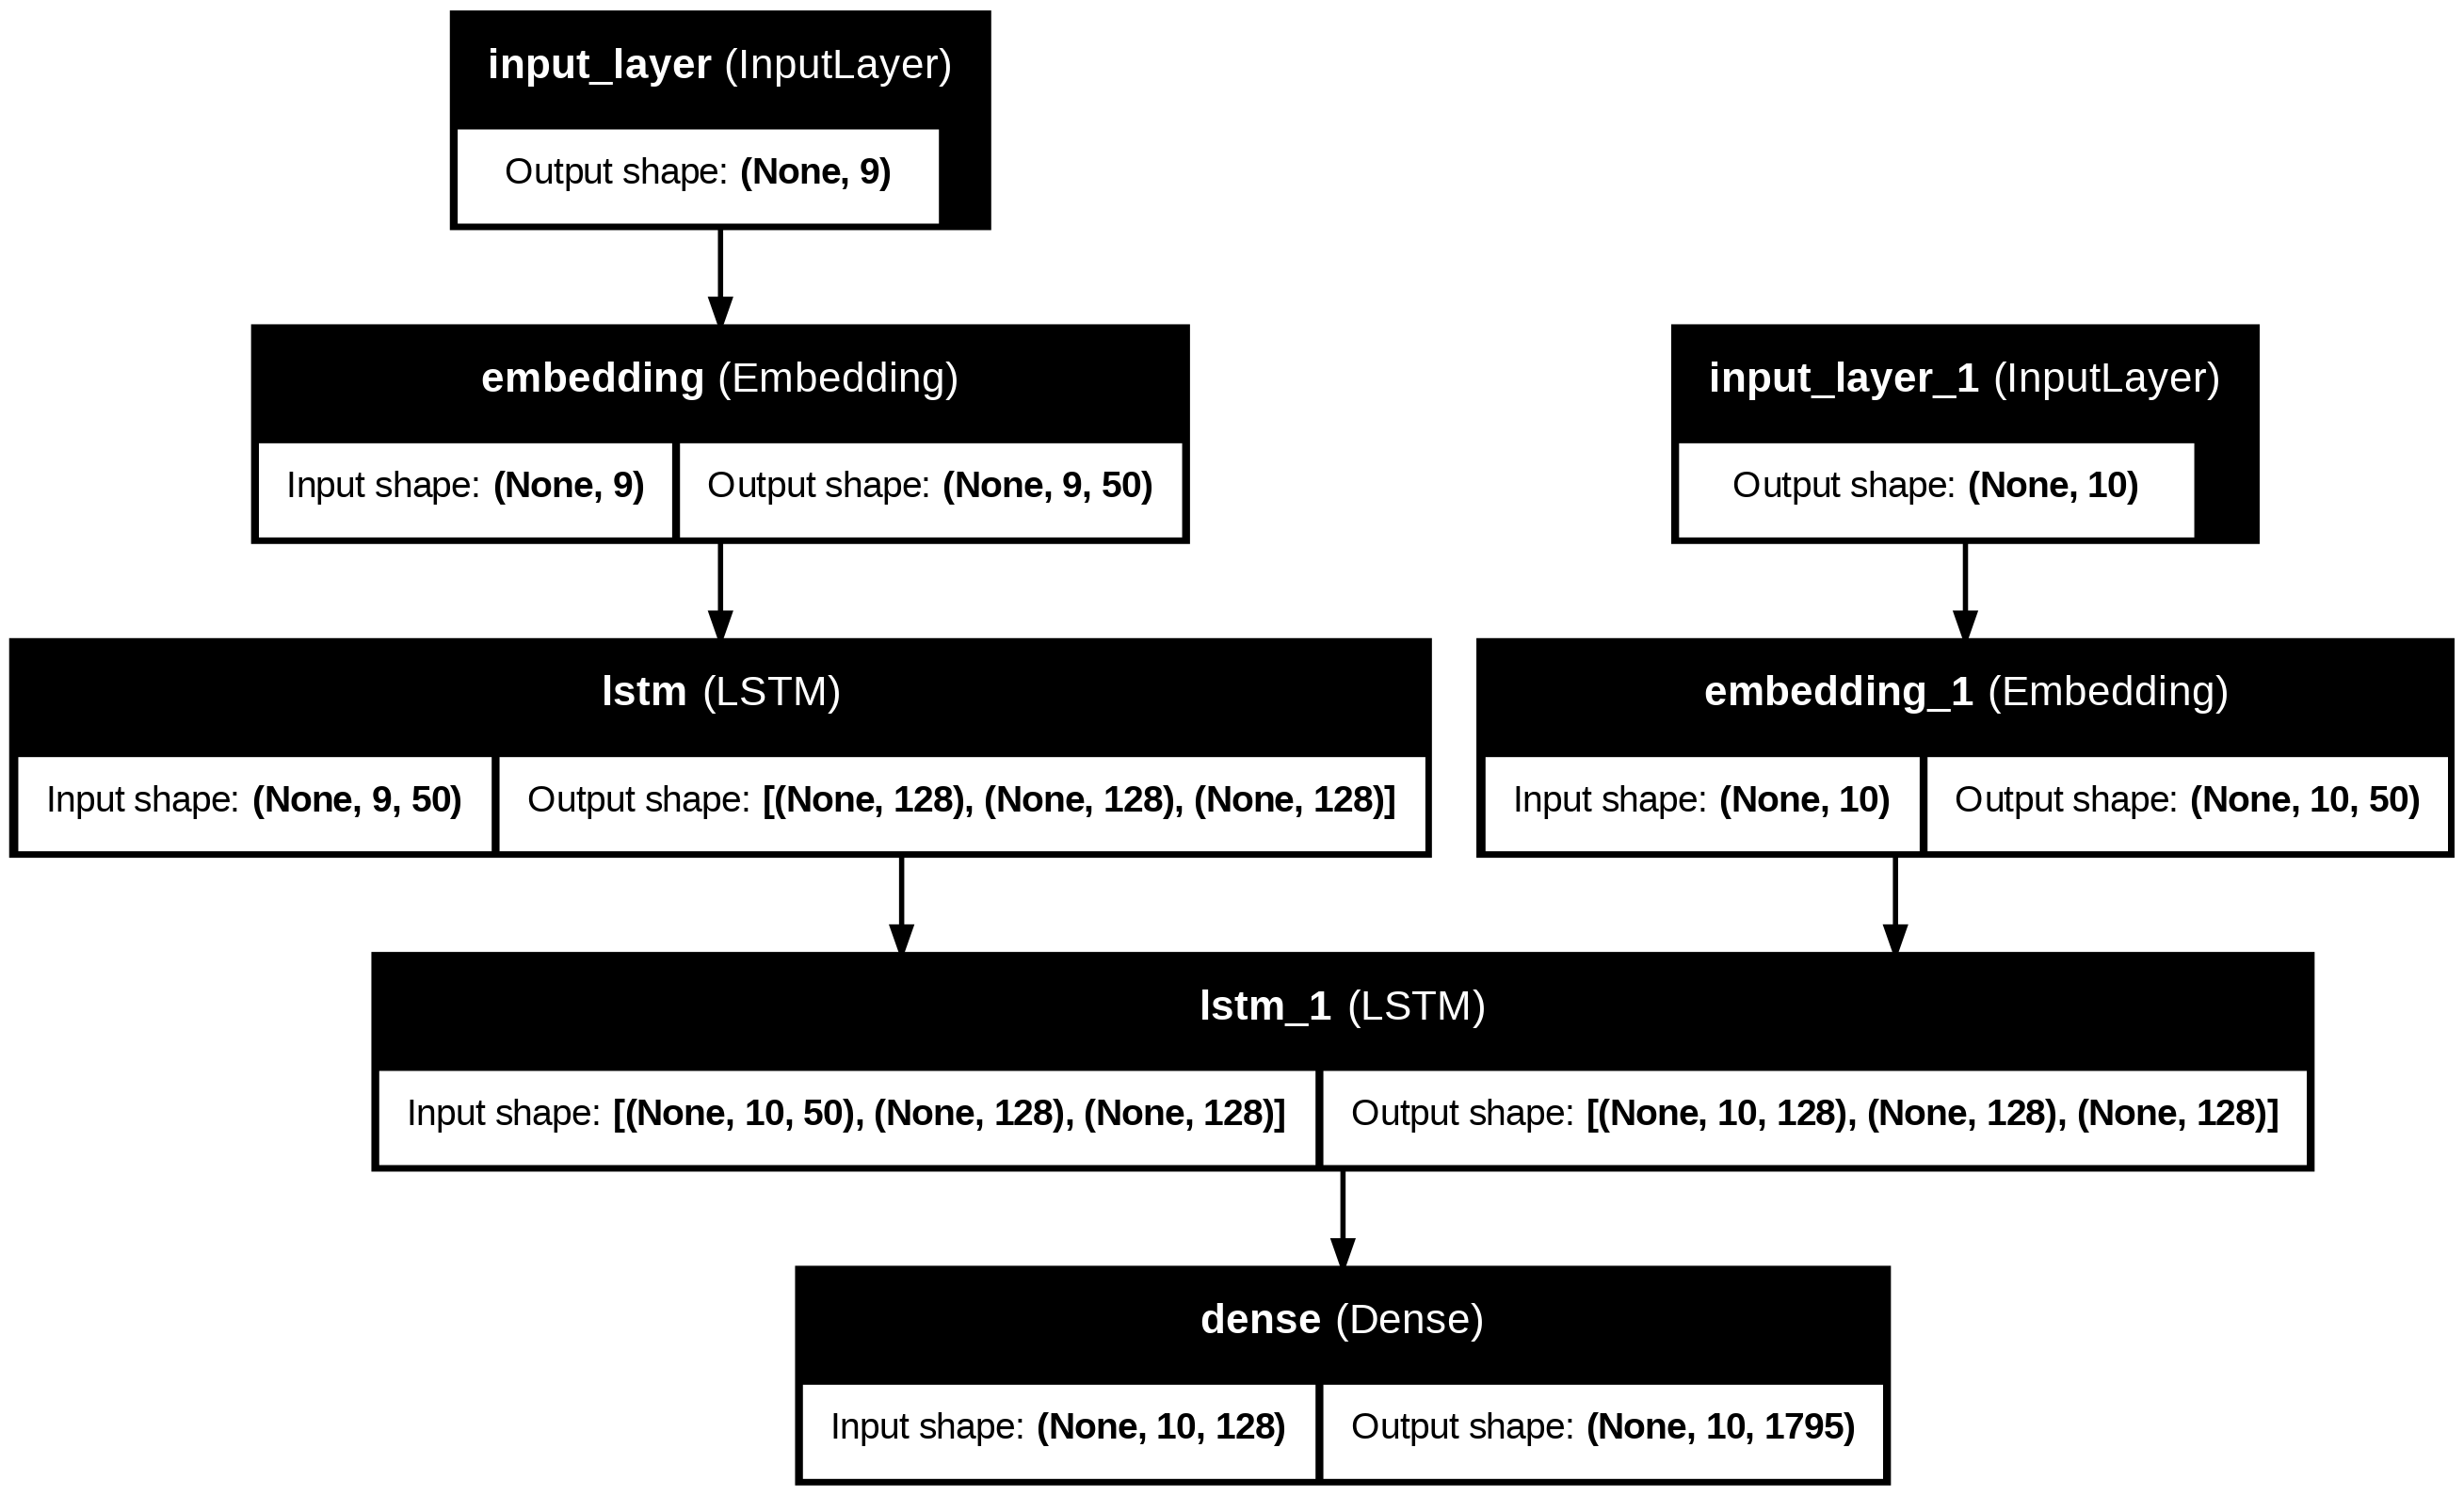

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Preparamos el objetivo para el entrenamiento (secuencia de salida)
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=vocab_size_out)

In [ ]:
# Entrenamos el modelo
hist = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets, batch_size=64, epochs=200, validation_split=0.2)

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 2.1954 - val_loss: 2.1793
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 234ms/step - loss: 2.0512 - val_loss: 2.1158
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - loss: 1.9810 - val_loss: 2.0280
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 1.8231 - val_loss: 1.9536
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - loss: 1.7303 - val_loss: 1.8909
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 1.6304 - val_loss: 1.8431
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 1.5488 - val_loss: 1.8061
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 1.4898 - val_loss: 1.7839
Epoch 9/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 1.4796 - val_loss: 1.7574
Epoch 10/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - loss: 1.4182 - val_loss: 1.7420
Epoch 11/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - loss: 1.3972 - val_loss: 1.7247
Epoch 12/200
75/75 ━━━━━━━━━━━

In [ ]:
# Guardar el modelo en una carpeta específica de Google Drive
model.save('/content/drive/My Drive/modelo.h5')

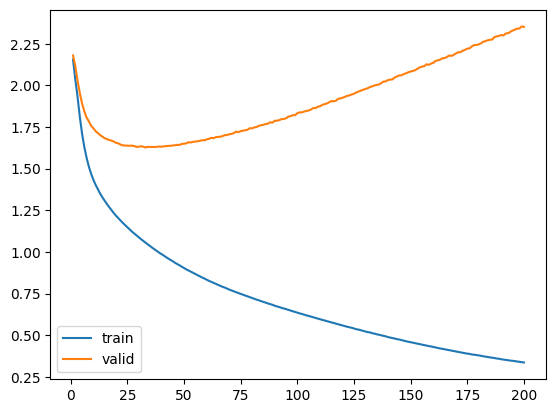

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

----------------------------------------

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
from tensorflow.keras.models import load_model

# Cargamos el modelo guardado desde Google Drive
model = load_model('/content/drive/My Drive/modelo.h5')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Diccionarios invertidos para convertir de índices a palabras
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

In [ ]:
# Función de traducción
def translate_sentence(input_seq):

    # Obtenemos los estados iniciales del encoder (h, c)
    states_value = encoder_model.predict(input_seq)

    # Inicializamos la secuencia del decoder con el token <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Token de fin de secuencia <eos>
    eos = word2idx_outputs['<eos>']

    # Lista para almacenar las palabras generadas
    output_sentence = []

    for _ in range(max_out_len):  # max_out_len: longitud máxima de la respuesta generada

        # Predecimos el siguiente token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si encontramos el token de fin de secuencia <eos>, detenemos la predicción
        if eos == idx:
            break

        # Convertimos el índice a la palabra correspondiente
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizamos los estados para la siguiente predicción
        states_value = [h, c]

        # Alimentamos el siguiente token como entrada
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
# Probamos con una frase
input_test = "hi there"
print('Input:', input_test)

# Convertimos la pregunta en una secuencia de enteros usando el tokenizer de entrada
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representación en vector de tokens:", integer_seq_test)

# Aplicamos padding para que la secuencia tenga la longitud adecuada para el encoder
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Vector con padding:", encoder_sequence_test)

# Realizamos la inferencia
print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: hi there
Representación en vector de tokens: [12, 49]
Vector con padding: [[ 0  0  0  0  0  0  0 12 49]]
Input: hi there
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Response: i i what what what what what what you what


### Análisis

Se interpreta que el modelo logra tokenizar la frase en inglés, no así las españolas, ya que el modelo fué entrenado en ese idioma. Por otro lado genera el vector con padding rellenando de 0 la cantidad adecuada y los tokens característicos que representan la frase. Luego da una respuesta, la cual es incoherente, posiblemente relacionado con sobreajuste y con el tamaño del dataset.